In [1]:
# Importing the required modules

In [2]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.6 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
import pickle
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'East Godavari']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
611,611,17.44,81.92,East Godavari,Gangavaram,Gangavaram,Red Soils,5.72,0.05,0.24,1.24,128.0,890.0,245.0,3.75,0.35,0.43,13.30,1.28,48.43,0.809552,0.677846,2.458942,4.629907,-0.698337,Topioca
612,612,17.44,81.92,East Godavari,Gangavaram,Gangavaram,Red Soils,5.45,0.06,0.32,1.83,105.0,727.0,169.0,4.15,0.57,0.49,16.71,1.54,61.84,0.809552,0.677846,2.458942,4.629907,-0.698337,"Topioca, Cashew"
613,613,17.43,81.92,East Godavari,Gangavaram,Gangavaram,Red Soils,5.93,0.08,0.39,2.12,77.0,734.0,169.0,7.12,0.47,0.51,24.27,1.72,47.76,0.667313,0.477157,1.611796,3.374576,-0.627878,Paddy
614,614,17.42,81.91,East Godavari,Gangavaram,Gangavaram,Red Soils,5.33,0.08,0.58,7.36,87.0,527.0,133.0,12.00,1.47,0.35,84.06,2.40,33.52,0.677633,0.494691,1.791405,3.501484,-0.636462,Paddy
615,615,17.42,81.91,East Godavari,Gangavaram,Gangavaram,Red Soils,6.95,0.05,0.23,1.23,57.0,1132.0,479.0,2.14,0.47,0.42,13.43,1.69,32.92,0.677633,0.494691,1.791405,3.501484,-0.636462,"Topica, Paddy"


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'ARVI', 'EVI', 'NDVI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,GCI
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,6.226818,0.209773,0.482273,12.031591,157.500000,953.750000,206.409091,9.929091,0.894091,0.422955,37.901591,1.845909,36.977727,3.518623
std,0.746171,0.495681,0.217286,18.528432,70.436348,753.495208,153.266346,11.099844,0.581147,0.166616,32.566430,0.899215,19.727601,0.811132
min,4.820000,0.040000,0.080000,0.740000,57.000000,223.000000,33.000000,1.040000,0.320000,0.170000,5.050000,0.500000,5.090000,2.341646
25%,5.767500,0.060000,0.357500,2.415000,106.500000,578.750000,126.750000,3.585000,0.550000,0.290000,13.397500,1.180000,22.590000,2.542274
50%,6.130000,0.090000,0.455000,4.915000,148.000000,753.500000,155.500000,5.695000,0.685000,0.420000,26.960000,1.705000,33.730000,3.777108
75%,6.672500,0.170000,0.580000,9.970000,188.000000,982.500000,245.500000,11.355000,0.972500,0.520000,50.015000,2.455000,47.927500,3.960036
max,8.000000,3.350000,1.180000,82.510000,392.000000,3794.000000,777.000000,56.310000,3.010000,0.810000,121.720000,4.410000,87.300000,4.859402


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Red Soils', 'Red sandy loam'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace('Red Soils', 'Red Soil')
df['SoilType'] = df['SoilType'].replace('Red sandy loam', 'Red Sandy Loam Soil')
df.SoilType.unique()

array(['Red Soil', 'Red Sandy Loam Soil'], dtype=object)

In [11]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Red Sandy Loam Soil': 13, 'Red Soil': 31}

<BarContainer object of 2 artists>

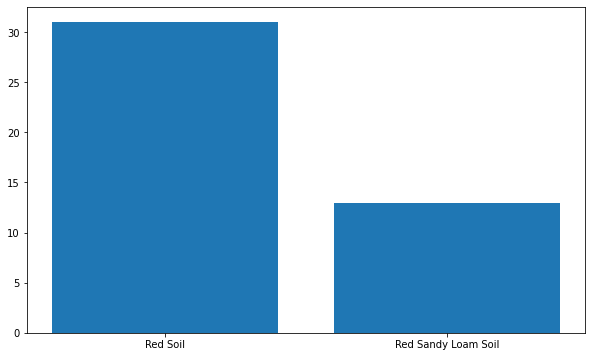

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['Topioca  ', 'Topioca, Cashew', 'Paddy', 'Topica, Paddy',
       'Topioca', 'Cashew, Mango', 'Topioca (Sample-2)',
       'Topioca (Sample-1)', 'Paddy (Sample-2)', 'Cotton (Sample-1)',
       'Cotton ', 'Cotton', 'Cotton, Topioca', 'Paddy, Brinjal',
       'Cotton, Redgram', 'Paddy (Sample-1)'], dtype=object)

In [15]:
df['Crop'].value_counts()

Paddy                 21
Cotton                 4
Topioca                4
Paddy (Sample-2)       2
Cotton (Sample-1)      2
Paddy (Sample-1)       1
Cotton, Redgram        1
Topioca, Cashew        1
Topioca (Sample-1)     1
Cashew, Mango          1
Cotton, Topioca        1
Topioca                1
Paddy, Brinjal         1
Topioca (Sample-2)     1
Topica, Paddy          1
Cotton                 1
Name: Crop, dtype: int64

Paddy      25
Tapioca     8
Cotton      8
Name: Crop, dtype: int64


<BarContainer object of 3 artists>

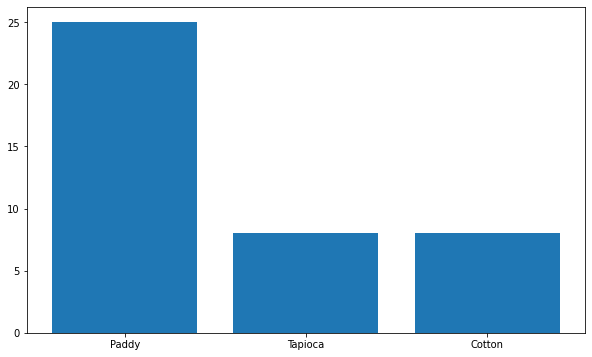

In [16]:
df['Crop'] = df['Crop'].replace(['Cotton (Sample-1)', 'Cotton ', 'Cotton', 'Cotton, Redgram'], 'Cotton')
df['Crop'] = df['Crop'].replace(['Paddy, Brinjal', 'Paddy (Sample-1)', 'Paddy (Sample-2)'], 'Paddy')
df['Crop'] = df['Crop'].replace(['Topioca', 'Topioca, Cashew', 'Topioca  ', 'Topioca (Sample-2)', 'Topioca (Sample-1)'], 'Tapioca')
df = df[(df['Crop'] != 'Topica, Paddy') & (df['Crop'] != 'Cashew, Mango') & (df['Crop'] != 'Cotton, Topioca')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
df = df[(df["Crop"] != 'SweetCorn') & (df["Crop"] != 'Mango') & (df["Crop"] != 'HorseGram')]

In [18]:
# Getting rid of features that have a high correlation among one another

In [19]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,GCI
pH,1.000000,0.350693,0.241096,0.127105,0.148829,0.695071,0.591943,0.188963,0.042814,0.043501,-0.141149,0.161902,-0.556459,-0.172606
EC,0.350693,1.000000,0.564192,0.163832,0.433282,0.563984,0.397651,0.758502,0.222021,0.528984,-0.033599,0.214563,-0.015411,-0.087200
OC,0.241096,0.564192,1.000000,0.296454,0.379856,0.282452,0.266818,0.508410,0.518181,0.539134,0.427353,0.611589,-0.016304,0.087396
P,0.127105,0.163832,0.296454,1.000000,0.236829,0.020361,0.018558,-0.066209,0.878455,0.076579,0.663295,0.462322,-0.154802,-0.304190
K,0.148829,0.433282,0.379856,0.236829,1.000000,0.112563,0.267932,0.095924,0.260360,0.464705,-0.060808,-0.074361,0.070945,-0.151196
Ca,0.695071,0.563984,0.282452,0.020361,0.112563,1.000000,0.766683,0.346891,-0.021570,0.273129,-0.143852,0.181346,-0.369081,-0.029764
Mg,0.591943,0.397651,0.266818,0.018558,0.267932,0.766683,1.000000,0.201328,0.075967,0.373499,-0.086178,0.273140,-0.210540,0.078182
S,0.188963,0.758502,0.508410,-0.066209,0.095924,0.346891,0.201328,1.000000,0.042084,0.389747,0.068553,0.338286,-0.088672,0.053813
Zn,0.042814,0.222021,0.518181,0.878455,0.260360,-0.021570,0.075967,0.042084,1.000000,0.185091,0.819179,0.623415,-0.016939,-0.233570
B,0.043501,0.528984,0.539134,0.076579,0.464705,0.273129,0.373499,0.389747,0.185091,1.000000,0.081734,0.277509,0.175012,0.012450


In [20]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)

Columns to be dropped :  ['OC', 'Ca', 'Mg', 'S', 'Zn', 'B', 'Fe', 'Cu']


In [21]:
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'P', 'K', 'Mn', 'GCI', 'Crop']


In [22]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [23]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

       pH    EC     P      K     Mn       GCI  Red Sandy Loam Soil  Red Soil
611  5.72  0.05  1.24  128.0  48.43  4.629907                    0         1
611    Tapioca
Name: Crop, dtype: object


In [24]:
# Standardizing the independent variables using Feature Scaling
sc = StandardScaler()
X[:, 0:6] = sc.fit_transform(X[:, 0:6])

In [25]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# SMOTE: Synthetic Minority Over-sampling Technique

In [26]:
# Separating the dependent and independent variables
df = df.drop(['SoilType'], axis=1)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [27]:
# Standardizing the independent variables using Feature Scaling
sc2 = StandardScaler()
X[:, :] = sc2.fit_transform(X[:, :])

In [28]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [29]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [30]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [31]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7368421052631579


In [32]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 66.33 %
Standard Deviation: 23.64 %


# Decision Tree Classifier

In [33]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [34]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [35]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6842105263157895


In [36]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 66.33 %
Standard Deviation: 20.14 %


# Random Forest Classifier

In [37]:
clf3_3 = RandomForestClassifier(random_state=0)
clf3_3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [38]:
y_test_pred = clf3_3.predict(X_test)
y_train_pred = clf3_3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [39]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.8421052631578947


In [40]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3_3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 71.33 %
Standard Deviation: 13.76 %


In [41]:
# pickle.dump(clf3_3, open('EG_model.pkl', 'wb'))
# pickle.dump(sc2, open('EG_scaler.pkl', 'wb'))

# XGBoost

In [42]:
clf4_4 = HistGradientBoostingClassifier(random_state=0)
clf4_4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [43]:
y_test_pred = clf4_4.predict(X_test)
y_train_pred = clf4_4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [44]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  0.9464285714285714
Testing Accuracy:  0.631578947368421


In [45]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4_4, X = X_train, y = y_train, cv = 10)

In [46]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 61.33 %
Standard Deviation: 22.17 %


In [47]:
# pickle.dump(clf4_4, open('Anantapur_model.pkl', 'wb'))
# pickle.dump(sc2, open('Anantapur_scaler.pkl', 'wb'))

# Multi-layer Perceptron Classifier

In [48]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [49]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [50]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.9107142857142857
Testing Accuracy:  0.7368421052631579


In [51]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 77.00 %
Standard Deviation: 22.58 %


# Catboost

In [52]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 1.0408381	total: 46.2ms	remaining: 4.58s
1:	learn: 0.9229429	total: 46.5ms	remaining: 2.28s
2:	learn: 0.8366136	total: 47.1ms	remaining: 1.52s
3:	learn: 0.7600321	total: 47.6ms	remaining: 1.14s
4:	learn: 0.5977273	total: 48.2ms	remaining: 915ms
5:	learn: 0.5510450	total: 48.7ms	remaining: 763ms
6:	learn: 0.5114406	total: 49.3ms	remaining: 655ms
7:	learn: 0.4680409	total: 49.9ms	remaining: 574ms
8:	learn: 0.3962448	total: 50.4ms	remaining: 510ms
9:	learn: 0.3774846	total: 51ms	remaining: 459ms
10:	learn: 0.3467873	total: 51.5ms	remaining: 417ms
11:	learn: 0.3343909	total: 52.1ms	remaining: 382ms
12:	learn: 0.2980573	total: 52.6ms	remaining: 352ms
13:	learn: 0.2701932	total: 53.2ms	remaining: 327ms
14:	learn: 0.2386750	total: 53.7ms	remaining: 304ms
15:	learn: 0.2299839	total: 53.9ms	remaining: 283ms
16:	learn: 0.2236684	total: 54.5ms	remaining: 266ms
17:	learn: 0.2165572	total: 55ms	remaining: 251ms
18:	learn: 0.2129093	total: 55.6ms	remaining: 237ms
19:	learn: 0.2023993	total

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8612734671
bestIteration = 98

Training on fold [1/5]

bestTest = 0.8417935234
bestIteration = 99

Training on fold [2/5]

bestTest = 0.9566708617
bestIteration = 99

Training on fold [3/5]

bestTest = 0.9469505567
bestIteration = 99

Training on fold [4/5]

bestTest = 0.8309400375
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 1.0131979	total: 1.83ms	remaining: 608ms
3:	learn: 0.9884311	total: 2.52ms	remaining: 626ms
4:	learn: 0.9662101	total: 3.17ms	remaining: 631ms
5:	learn: 0.9379918	total: 3.82ms	remaining: 633ms
6:	learn: 0.9159627	total: 4.49ms	remaining: 636ms
7:	learn: 0.8989016	total: 5.13ms	remaining: 636ms
8:	learn: 0.8734598	total: 5.78ms	remaining: 636ms
9:	learn: 0.8641482	total: 6.42ms	remaining: 635ms
10:	learn: 0.8426500	total: 7.1ms	remaining: 639ms
11:	learn: 0.8294279	total: 7.78ms	remaining: 640ms
12:	learn: 0.8131561	total: 8.47ms	remaining: 643ms
13:	learn: 0.7886515	total: 9.18ms	remaining: 647ms
14:	learn: 0.7749939	total: 9.91ms	remaining: 651ms
15:	learn: 0.7611072	total: 10.6ms	remaining: 650ms
16:	learn: 0.7489086	total: 11.3ms	remaining: 652ms
17:	learn: 0.7345399	total: 11.9ms	remaining: 652ms
18:	learn: 0.7212532	total: 12.6ms	remaining: 652ms
19:	learn: 0.7139227	total: 13.3ms	remaining: 654ms
20:	learn: 0.7041713	t